## 5.8 Invertendo a projeção

$x, y$: coordenadas na imagem

$\breve x, \breve y$: coodenadas projetadas do modelo não linear de distorção

$\hat x, \hat y$: coordenadas da projeção unitária no ponto

$\tilde x, \tilde y, \tilde z$: coordenadas do ponto no referencial da câmera

$x^\prime, y^\prime, z^\prime$: coordenadas do ponto no sistema global

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

from ipywidgets import interact

In [2]:
mtx = np.array([[772.07218515,   0.        , 634.15206573],
                [  0.        , 771.9959048 , 366.5862172 ],
                [  0.        ,   0.        ,   1.        ]])
dist = np.array([[ 0.09361794, -0.22823167,  0.00027023, -0.00095334,  0.09892737]])

---

1 - Chame a função undistortPoints com o ponto no canto superior esquerdo da imagem (0, 0), no canto inferior direito (1279, 719), o ponto central (639, 359) e o ponto central inferior (1279, 719). Quais as coordenadas de projeção ideal correspondem a cada um destes pontos?

In [3]:
# obtendo os coeficientes da projeção ideal
pontos = np.array([[0, 0], [1279, 719], [639, 359], [639, 719]])
novos_pontos = cv2.undistortPoints(np.float32(pontos), mtx, dist)

In [4]:
pontos

array([[   0,    0],
       [1279,  719],
       [ 639,  359],
       [ 639,  719]])

In [5]:
novos_pontos

array([[[-0.8471021 , -0.4905479 ]],

       [[ 0.8668285 ,  0.4729746 ]],

       [[ 0.00627928, -0.00982684]],

       [[ 0.00640525,  0.45162222]]], dtype=float32)

In [6]:
mtx[:2,2]

array([634.15206573, 366.5862172 ])

In [7]:
# Obs: essa parte (acho) está errada
# eu não estou entendendo a apostila
# isso é muito difícil

# coordenadas projetadas do modelo não linear de distorção
# feito de acordo com a equação 5.9 da apostila
coords_proj = []
for n_p in novos_pontos:
    n_p = n_p[0]
    d = dist[0]
    r2 = (n_p[0]**2 + n_p[1]**2)
    c_p_x = n_p[0]*(d[0]*r2 + d[1]*r2**2 + d[4]*r2**3) + 2*d[2]*n_p[0]*n_p[1] + d[3]*(r2 + n_p[0]**2)
    c_p_y = n_p[1]*(d[0]*r2 + d[1]*r2**2 + d[4]*r2**3) + 2*d[3]*n_p[0]*n_p[1] + d[2]*(r2 + n_p[1]**2)
    coords_proj.append([c_p_x, c_p_y])
print(coords_proj)

[[0.02642356075987068, 0.015628365931442127], [-0.030896669253607484, -0.01653898274380406], [-1.2067020365029393e-07, 5.542737839702804e-08], [-0.000126090511580898, 0.004819609885025494]]


In [8]:
# essa parte (acho) está certa (???)
# coordenadas na imagem
coords_imagem = novos_pontos@mtx[:2,:2]
for i in range(len(coords_imagem)):
    coords_imagem[i] += mtx[:2,2]

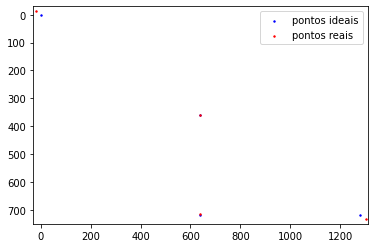

In [9]:
# visualizando os pontos da projeção ideal em relação aos pontos reais

size = 2
plt.scatter(pontos[:,0], pontos[:,1], color="blue", s=size, label="pontos ideais")
plt.scatter(coords_imagem[:,0][:,0], coords_imagem[:,0][:,1], color="red", s=size, label="pontos reais")
plt.legend()
plt.xlim(-30, 1310)
plt.ylim(750, -30)
plt.show()

---

2 - Qual a equação (ou seja $[x^\prime(\lambda), y^\prime(\lambda), z^\prime(\lambda)]$) da reta correspondente
ao ponto central?

$X^\prime(\lambda)=\lambda R^T \hat X + X^\prime_0$

onde $X^\prime_0 = -R^Tt$

In [10]:
R = np.array([[ 0.02615377, -0.99965591, -0.00201007],
              [-0.62292082, -0.01472463, -0.7821463 ],
              [ 0.78184757,  0.02170819, -0.62309159]])
t = np.array([-1.57344933, 80.92147334, 44.30539103])

In [11]:
ponto_central = pontos[2]
X_chapeu = [novos_pontos[2][0][0], novos_pontos[2][0][1], 1]
lamb = 1
def X_linha(lamb):
    return lamb*R.T@X_chapeu - R.T@t
print(f"lambda*{R.T@X_chapeu}+{- R.T@t}")

lambda*[ 0.78813314  0.01557577 -0.61541819]+[15.80875985 -1.34315901 90.89558476]


In [12]:
# função que recebe um ponto nas coordenadas da imagem, um valor lambda de distância da câmera
# e retorna o ponto equivalente nas coordenadas globais
def imagem2global(p, lamb):
    p = cv2.undistortPoints(np.float32(p), mtx, dist)
    p = [*p[0][0], 1]
    return lamb*R.T@p - R.T@t

Pontos da reta central:
Ponto inicial: [15.80875985 -1.34315901 90.89558476]
Ponto final: [70.97807964 -0.25285521 47.81631179]


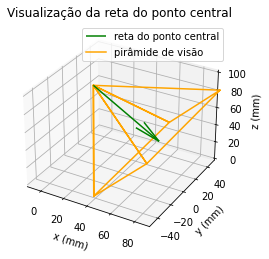

In [13]:
# visualização da reta que passa pelo ponto central e da pirâmide de visão

# %matplotlib notebook

# obs: lambda não é uma medida em milímetros
lamb = 70

p0 = X_linha(0)
p1 = X_linha(lamb)

print("Pontos da reta central:")
print(f'Ponto inicial: {p0}')
print(f'Ponto final: {p1}')

cantos_imagem = [[0, 0], [0, 719], [1279,  719], [1279, 0], [0, 0]]
pontos_base_piramide = []
for c in cantos_imagem:
    pontos_base_piramide.append(imagem2global(c, lamb))

# criando a lista de vértices da piramide:
vertices_piramide = [[], [], []]
for j in range(3):
    for i in range(len(pontos_base_piramide)-1):
        vertices_piramide[j].append(p0[j])
        vertices_piramide[j].append(pontos_base_piramide[i][j])
        vertices_piramide[j].append(pontos_base_piramide[i+1][j])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(*p0, *(p1-p0), color='green', label='reta do ponto central')
ax.plot(vertices_piramide[0], vertices_piramide[1], vertices_piramide[2], color='orange', label='pirâmide de visão')
ax.set_xlim([-10, 90])
ax.set_ylim([-50, 50])
ax.set_zlim([0, 100])

plt.title("Visualização da reta do ponto central")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel("z (mm)")
plt.legend()
plt.show()

Dados da câmera:

logitech C930e

---

3 - Considere a reta que passa pelo ponto central inferior e o ponto no qual esta reta cruza o plano z′ = 0. Qual a coordenada x′ deste ponto? Note que este é o ponto no solo mais próximo do robô que ainda é visı́vel pela câmera.

In [14]:
@interact(lamb=(85.0,95.0, 0.001))
def func(lamb=93.1):
    cd = imagem2global([639, 719], lamb)
    print(f'[{cd[0]:.3f}, {cd[1]:.3f}, {cd[2]:.3f}]')

interactive(children=(FloatSlider(value=93.1, description='lamb', max=95.0, min=85.0, step=0.001), Output()), …

---

4 - Considere a reta que passa pelo ponto no canto superior esquerdo e a que passa pelo ponto no canto inferior direito. Ambas as retas passam pelo centro de projeção da câmera. Sabendo que o produto interno de dois vetores $\vec{v1}\cdot\vec{v2}$ é $|\vec{v1}||\vec{v2}| cos\theta$, onde $\theta$ é o ângulo entre os vetores, qual é o ângulo formado pelas retas?

$cos\theta = \frac{\vec{v1} \cdot \vec{v2}}{|\vec{v1}||\vec{v2}|}$

$\theta = arccos\left(\frac{\vec{v1} \cdot \vec{v2}}{|\vec{v1}||\vec{v2}|}\right)$

In [15]:
s_e = [0,0]
i_d = [1279, 719]

v1 = np.array(imagem2global(s_e, 100))
v2 = np.array(imagem2global(i_d, 100))

theta = math.acos((v1@v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))

print('ângulo entre os vetores:')
print(f'{theta:.3f} rad')
print(f'{180*theta/math.pi:.1f}°')

ângulo entre os vetores:
1.563 rad
89.6°


---

## 5.8.1 Um caso especial: $z' = 0$

1 - A partir da matriz R e do vetor t, calcule a matriz S de projeção reversa para $z' = 0$

In [16]:
P = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])

G = np.eye(4)
G[0:3,0:3] = R
G[0:3,3] = t
G

array([[ 2.61537700e-02, -9.99655910e-01, -2.01007000e-03,
        -1.57344933e+00],
       [-6.22920820e-01, -1.47246300e-02, -7.82146300e-01,
         8.09214733e+01],
       [ 7.81847570e-01,  2.17081900e-02, -6.23091590e-01,
         4.43053910e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [17]:
N = P@G
Nz = np.eye(3)
Nz[0:3, 0:2] = N[0:3,0:2]
Nz[0:3, 2] = N[:,3]
Nz

array([[ 2.61537700e-02, -9.99655910e-01, -1.57344933e+00],
       [-6.22920820e-01, -1.47246300e-02,  8.09214733e+01],
       [ 7.81847570e-01,  2.17081900e-02,  4.43053910e+01]])

In [18]:
Q = np.linalg.inv(Nz)
Q

array([[ 2.65033690e-02, -4.86888221e-01,  8.90217037e-01],
       [-9.99685614e-01, -2.62823609e-02,  1.25007971e-02],
       [ 2.21140262e-05,  8.60488772e-03,  6.85502591e-03]])

In [19]:
S = Q/Q[2][2]
S

array([[ 3.86626825e+00, -7.10264597e+01,  1.29863410e+02],
       [-1.45832507e+02, -3.83402794e+00,  1.82359590e+00],
       [ 3.22595808e-03,  1.25526699e+00,  1.00000000e+00]])

---

2 - Na seção 5.7 você calculou as coordenadas da imagem correspondentes ao ponto (154, 55, 0), 0, 0). Vamos agora inverter este cálculo. Primeiro calcule as coordenadas de projeção ideal (x̂, ŷ) com os parâmetros intrı́nsecos fazendo uma chamada a undistortPoints. Depois, calcule com a matriz S as coordenadas x', y' correspondentes a este ponto. Compare o valor com o esperado.

In [20]:
# TODO

---

Reproduza o processo de reconstrução do Logotipo com uma imagem qualquer à sua escolha. Tente variar os parâmetros mtx2 e dim e observe que efeito eles produzem na imagem final.

In [21]:
#mtx2 = np.eye(3)
mtx2 = np.float32([[4,  0,     0],
                   [0, -4, 4*105],
                   [0,  0,     1]])
dim = (4*297, 4*210)
tipo_mapa = cv2.CV_32FC1
mapa_x, mapa_y = cv2.initUndistortRectifyMap(mtx, dist, S, mtx2, dim, tipo_mapa)

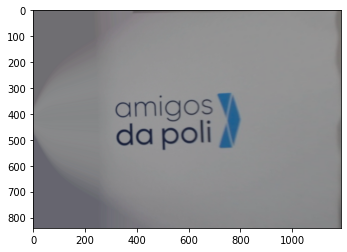

In [22]:
imagem_adp = cv2.imread("adp1.jpg")
borda = cv2.BORDER_REPLICATE
# tipos de borda:
# cv2.BORDER_CONSTANT
# cv2.BORDER_REFLECT
# cv2.BORDER_REFLECT_101
# cv2.BORDER_REPLICATE
# cv2.BORDER_WRAP

imagem_adp_remapeada = cv2.remap(imagem_adp, mapa_x, mapa_y, cv2.INTER_LINEAR, borderMode=borda)

# plt.xlim(400, 650)
# plt.ylim(250, 500)
plt.clf()
plt.imshow(imagem_adp_remapeada)